<a href="https://colab.research.google.com/github/vksriharsha/Causal-Inference-on-Gene-Expression-Data/blob/main/PCA_CMI_HumanCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pycm

     |████████████████████████████████| 65 kB 3.1 MB/s 
     |████████████████████████████████| 574 kB 26.6 MB/s 


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from pycm import *
from matplotlib.pyplot import figure
import seaborn as sn

In [4]:
import time
import os
import numpy as np
import pandas as pd
import argparse
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy import interpolate
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr
import scipy.sparse
import sys
import pickle
import re
from scipy import stats
from numpy import savetxt
from numpy import genfromtxt
import networkx as nx
from scipy.stats import norm
import itertools
import math
import copy
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.metrics import confusion_matrix
from pycm import *

In [5]:
tcga_data_df = pd.read_csv('/content/drive/MyDrive/Thesis/Human-Cancer-Prediction/TCGA_GTEX_Data_18212_7142.tsv', delimiter='\t')

tcga_metadata_df = pd.read_csv('/content/drive/MyDrive/Thesis/Human-Cancer-Prediction/TCGA_GTEX_MetaData_7142_23.tsv', delimiter='\t')

tcga_data_df = tcga_data_df.drop(['NCBI_description','NCBI_other_designations','NCBI_chromosome', 'NCBI_map_location', 'NCBI_OMIM', 'CGC_Tumour Types(Somatic)', 'CGC_Tumour Types(Germline)', 'CGC_Role in Cancer', 'CGC_Translocation Partner', 'CGC_Somatic', 'CGC_Germline', 'CGC_Mutation Types', 'CGC_Molecular Genetics', 'CGC_Tissue Type', 'CGC_Cancer Syndrome', 'CGC_Other Syndrome', 'OMIM_Comments', 'OMIM_Phenotypes', 'Hugo_RefSeq IDs', 'Hugo_Ensembl gene ID', 'Hugo_Enzyme IDs', 'Hugo_Pubmed IDs', 'Hugo_Locus group', 'Hugo_Gene group name'],axis=1)

tcga_data_df = tcga_data_df.T

tcga_data_df.columns = tcga_data_df.iloc[0]

tcga_data_df = tcga_data_df.drop(tcga_data_df.index[0])

def x(a):
    return np.log2(a.astype('float32') + 1)

tcga_data_df  = tcga_data_df.apply(x, axis = 1)

tcga_data_df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Hugo_Symbol,KIF1C,SWAP70,PAK1,PLEKHM3,MCFD2,RBM12,KRT86,PSMD12,SLC7A11,BTN3A1,SFTPB,LPIN1,NT5C1A,L3MBTL2,SLC9A9,ST7L,SYT2,CACNA2D4,ZNF84,RBP2,HLA-DQB1,DPP4,LRRC36,ATP5D,LAMB3,MRPL34,C19orf57,BNIP3L,NT5DC2,CFP,C4orf47,TSFM,DDR1,MEIS3,OR2H2,SCNN1G,KIF1B,PMEPA1,MARVELD3,C9orf152,...,MMP21,KIAA0319L,WDR61,TMEM5,NPDC1,LGALS9C,CCM2,MT1G,NDOR1,TLCD1,STX7,METTL5,FJX1,FGF7,TPPP2,RBM10,OPCML,CA10,PNPT1,FILIP1L,COA3,SLC22A7,ARHGEF15,PLCB1,STAC3,AFG3L2,FAM120A,SRGAP3,PRMT5,CREG2,SLC39A7,CCDC138,SLC39A8,ZNF221,NNAT,EID3,ZNF740,ELP4,SPSB2,BCL2L12
TCGA-AC-A2BM-01A-11R-A21T-07,9.929998,8.599987,9.549996,5.009885,9.860001,9.970005,1.007195,9.929998,5.759955,8.330021,1.021480,7.980025,0.659925,9.189998,5.889960,8.830009,0.422233,5.809929,9.329998,5.800123,11.749999,6.200065,3.819668,10.679999,6.720005,10.800002,6.709980,10.640001,8.479982,4.149747,7.290019,10.360003,11.779999,8.479982,1.201634,9.549996,7.620000,8.219992,6.839960,4.609991,...,1.201634,10.389997,10.969998,9.159997,10.830000,2.010780,9.609991,5.839960,6.980025,8.470008,8.140012,9.840007,7.750003,5.720005,0.000000,9.199991,1.298658,0.000000,8.669984,8.299987,11.520000,0.000000,6.109987,4.250204,6.239933,10.110001,10.979997,6.519951,9.420002,1.632268,11.159997,6.579995,8.659996,3.710393,4.210233,5.870118,9.369989,7.760021,8.589988,9.009996
TCGA-A8-A075-01A-11R-A084-07,10.260002,9.170000,9.439997,4.599913,10.339994,9.779999,5.020146,10.110001,2.639232,8.639992,3.829849,6.900022,0.000000,8.330021,5.449892,7.400025,0.790772,6.390083,8.559989,1.448901,12.620000,6.829977,1.056584,10.929998,7.199967,9.720005,5.300124,10.620000,11.700002,4.539779,5.189825,10.189998,12.000000,8.579994,0.000000,0.000000,7.570007,11.199997,8.500006,8.880013,...,1.669027,9.439997,10.110001,8.119979,11.629998,1.049631,9.790007,7.900022,7.849999,9.000000,10.049998,9.890006,6.859970,6.930027,1.250962,9.590007,2.879706,0.411426,8.659996,9.069986,10.409995,0.000000,6.319943,5.930027,6.179909,9.900006,10.229997,5.549977,10.520000,2.021480,12.420000,6.660067,7.819987,5.429951,4.580145,5.780047,8.839991,8.729995,6.280028,9.300009
TCGA-A2-A0EM-01A-11R-A034-07,10.350000,9.520010,10.630003,4.550285,10.090007,9.729995,2.659925,9.520010,3.350497,7.440039,0.000000,6.950002,0.731183,9.260002,5.460087,8.559989,0.782409,6.229972,8.339984,2.669027,11.720000,4.869872,4.929791,10.759996,9.030005,10.580004,5.640100,11.029998,9.840007,5.209843,3.379898,10.350000,11.600001,8.880013,0.000000,3.410070,7.510013,10.339994,8.360013,7.890021,...,0.475085,10.030005,10.339994,8.219992,9.520010,3.900142,9.140012,6.559950,6.799994,8.919995,8.899991,10.150001,6.770036,7.309977,0.000000,9.249990,0.400538,0.000000,7.950002,8.439997,11.629998,0.000000,7.009996,5.229972,5.629940,10.299997,10.960002,6.789990,10.800002,2.130931,11.269998,6.330020,8.550015,5.060048,4.149747,5.239933,9.079991,8.140012,6.609991,8.809993
TCGA-A7-A3J1-01A-11R-A213-07,10.810001,9.309999,10.049998,5.640100,9.799994,9.879996,4.550285,9.269992,4.689858,9.740000,2.650765,8.160023,1.189034,9.039989,7.049957,8.559989,1.232661,7.149951,8.439997,5.300124,13.450000,7.009996,4.659925,11.760000,7.869995,10.599997,6.720005,10.520000,9.030005,6.349967,5.520108,9.799994,11.469997,9.130004,0.000000,4.609991,7.730029,10.139998,7.980025,8.710014,...,1.778209,10.709997,10.049998,8.620000,12.179999,6.129901,10.080005,8.209990,8.409985,8.050012,9.109987,9.849999,6.559950,7.360013,0.739848,9.670001,1.541019,0.389567,8.500006,8.080018,11.769999,0.000000,8.579994,5.960002,6.700024,9.340006,11.399999,6.290019,9.639992,2.280956,10.430003,6.470049,7.220040,4.829850,5.800123,5.000000,9.380007,7.520030,8.130004,8.530016
TCGA-BH-A0BO-01A-23R-A12D-07,10.610001,10.709997,9.990005,5.020146,10.379995,10.280005,5.710118,10.130004,3.620586,8.780015,0.000000,8.310022,0.731183,8.809993,6.479942,8.409985,1.049631,6.040016,8.759988,0.000000,12.010000,7.859970,3.789729,10.630003,9.909998,9.770003,5.910013,10.909998,9.140012,7.939991,5.599913,9.960002,11.700002,9.059994,1.077243,4.450222,8.150001,10.580004,8.330

In [6]:
tcga_metadata_df = tcga_metadata_df[['portions.analytes.aliquots.submitter_id', 'clinical.disease']]
tcga_metadata_df['clinical.disease'] = tcga_metadata_df['clinical.disease'].fillna('normal')
tcga_metadata_df = tcga_metadata_df.set_index('portions.analytes.aliquots.submitter_id')

tcga_metadata_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,clinical.disease
portions.analytes.aliquots.submitter_id,
TCGA-3C-AAAU-01A-11R-A41B-07,BRCA
TCGA-3C-AALI-01A-11R-A41B-07,BRCA
TCGA-3C-AALJ-01A-31R-A41B-07,BRCA
TCGA-3C-AALK-01A-11R-A41B-07,BRCA
TCGA-4H-AAAK-01A-12R-A41B-07,BRCA
...,...
GTEX-ZZPU-0526-SM-5E44U,Lung_normal
GTEX-ZZPU-0626-SM-5E43T,Breast_normal
GTEX-ZZPU-1326-SM-5GZWS,Thyroid_normal


In [7]:
tcga_data_df = pd.merge(tcga_data_df, tcga_metadata_df, left_index=True, right_index=True)

tcga_data_df

,KIF1C,SWAP70,PAK1,PLEKHM3,MCFD2,RBM12,KRT86,PSMD12,SLC7A11,BTN3A1,SFTPB,LPIN1,NT5C1A,L3MBTL2,SLC9A9,ST7L,SYT2,CACNA2D4,ZNF84,RBP2,HLA-DQB1,DPP4,LRRC36,ATP5D,LAMB3,MRPL34,C19orf57,BNIP3L,NT5DC2,CFP,C4orf47,TSFM,DDR1,MEIS3,OR2H2,SCNN1G,KIF1B,PMEPA1,MARVELD3,C9orf152,...,KIAA0319L,WDR61,TMEM5,NPDC1,LGALS9C,CCM2,MT1G,NDOR1,TLCD1,STX7,METTL5,FJX1,FGF7,TPPP2,RBM10,OPCML,CA10,PNPT1,FILIP1L,COA3,SLC22A7,ARHGEF15,PLCB1,STAC3,AFG3L2,FAM120A,SRGAP3,PRMT5,CREG2,SLC39A7,CCDC138,SLC39A8,ZNF221,NNAT,EID3,ZNF740,ELP4,SPSB2,BCL2L12,clinical.disease
TCGA-AC-A2BM-01A-11R-A21T-07,9.929998,8.599987,9.549996,5.009885,9.860001,9.970005,1.007195,9.929998,5.759955,8.330021,1.021480,7.980025,0.659925,9.189998,5.889960,8.830009,0.422233,5.809929,9.329998,5.800123,11.749999,6.200065,3.819668,10.679999,6.720005,10.800002,6.709980,10.640001,8.479982,4.149747,7.290019,10.360003,11.779999,8.479982,1.201634,9.549996,7.620000,8.219992,6.839960,4.609991,...,10.389997,10.969998,9.159997,10.830000,2.010780,9.609991,5.839960,6.980025,8.470008,8.140012,9.840007,7.750003,5.720005,0.000000,9.199991,1.298658,0.000000,8.669984,8.299987,11.520000,0.000000,6.109987,4.250204,6.239933,10.110001,10.979997,6.519951,9.420002,1.632268,11.159997,6.579995,8.659996,3.710393,4.210233,5.870118,9.369989,7.760021,8.589988,9.009996,BRCA
TCGA-A8-A075-01A-11R-A084-07,10.260002,9.170000,9.439997,4.599913,10.339994,9.779999,5.020146,10.110001,2.639232,8.639992,3.829849,6.900022,0.000000,8.330021,5.449892,7.400025,0.790772,6.390083,8.559989,1.448901,12.620000,6.829977,1.056584,10.929998,7.199967,9.720005,5.300124,10.620000,11.700002,4.539779,5.189825,10.189998,12.000000,8.579994,0.000000,0.000000,7.570007,11.199997,8.500006,8.880013,...,9.439997,10.110001,8.119979,11.629998,1.049631,9.790007,7.900022,7.849999,9.000000,10.049998,9.890006,6.859970,6.930027,1.250962,9.590007,2.879706,0.411426,8.659996,9.069986,10.409995,0.000000,6.319943,5.930027,6.179909,9.900006,10.229997,5.549977,10.520000,2.021480,12.420000,6.660067,7.819987,5.429951,4.580145,5.780047,8.839991,8.729995,6.280028,9.300009,BRCA
TCGA-A2-A0EM-01A-11R-A034-07,10.350000,9.520010,10.630003,4.550285,10.090007,9.729995,2.659925,9.520010,3.350497,7.440039,0.000000,6.950002,0.731183,9.260002,5.460087,8.559989,0.782409,6.229972,8.339984,2.669027,11.720000,4.869872,4.929791,10.759996,9.030005,10.580004,5.640100,11.029998,9.840007,5.209843,3.379898,10.350000,11.600001,8.880013,0.000000,3.410070,7.510013,10.339994,8.360013,7.890021,...,10.030005,10.339994,8.219992,9.520010,3.900142,9.140012,6.559950,6.799994,8.919995,8.899991,10.150001,6.770036,7.309977,0.000000,9.249990,0.400538,0.000000,7.950002,8.439997,11.629998,0.000000,7.009996,5.229972,5.629940,10.299997,10.960002,6.789990,10.800002,2.130931,11.269998,6.330020,8.550015,5.060048,4.149747,5.239933,9.079991,8.140012,6.609991,8.809993,BRCA
TCGA-A7-A3J1-01A-11R-A213-07,10.810001,9.309999,10.049998,5.640100,9.799994,9.879996,4.550285,9.269992,4.689858,9.740000,2.650765,8.160023,1.189034,9.039989,7.049957,8.559989,1.232661,7.149951,8.439997,5.300124,13.450000,7.009996,4.659925,11.760000,7.869995,10.599997,6.720005,10.520000,9.030005,6.349967,5.520108,9.799994,11.469997,9.130004,0.000000,4.609991,7.730029,10.139998,7.980025,8.710014,...,10.709997,10.049998,8.620000,12.179999,6.129901,10.080005,8.209990,8.409985,8.050012,9.109987,9.849999,6.559950,7.360013,0.739848,9.670001,1.541019,0.389567,8.500006,8.080018,11.769999,0.000000,8.579994,5.960002,6.700024,9.340006,11.399999,6.290019,9.639992,2.280956,10.430003,6.470049,7.220040,4.829850,5.800123,5.000000,9.380007,7.520030,8.130004,8.530016,BRCA
TCGA-BH-A0BO-01A-23R-A12D-07,10.610001,10.709997,9.990005,5.020146,10.379995,10.280005,5.710118,10.130004,3.620586,8.780015,0.000000,8.310022,0.731183,8.809993,6.479942,8.409985,1.049631,6.040016,8.759988,0.000000,12.010000,7.859970,3.789729,10.630003,9.909998,9.770003,5.910013,10.909998,9.140012,7.939991,5.599913,9.960002,11.700002,9.059994,1.077243,4.450222,8.150001,10.580004,8.330021,7.919995,...

In [8]:
some_values = ['BRCA', 'Breast_normal']
tcga_data_breast_df = tcga_data_df.loc[tcga_data_df['clinical.disease'].isin(some_values)]

In [9]:
tcga_data_breast_df

,KIF1C,SWAP70,PAK1,PLEKHM3,MCFD2,RBM12,KRT86,PSMD12,SLC7A11,BTN3A1,SFTPB,LPIN1,NT5C1A,L3MBTL2,SLC9A9,ST7L,SYT2,CACNA2D4,ZNF84,RBP2,HLA-DQB1,DPP4,LRRC36,ATP5D,LAMB3,MRPL34,C19orf57,BNIP3L,NT5DC2,CFP,C4orf47,TSFM,DDR1,MEIS3,OR2H2,SCNN1G,KIF1B,PMEPA1,MARVELD3,C9orf152,...,KIAA0319L,WDR61,TMEM5,NPDC1,LGALS9C,CCM2,MT1G,NDOR1,TLCD1,STX7,METTL5,FJX1,FGF7,TPPP2,RBM10,OPCML,CA10,PNPT1,FILIP1L,COA3,SLC22A7,ARHGEF15,PLCB1,STAC3,AFG3L2,FAM120A,SRGAP3,PRMT5,CREG2,SLC39A7,CCDC138,SLC39A8,ZNF221,NNAT,EID3,ZNF740,ELP4,SPSB2,BCL2L12,clinical.disease
TCGA-AC-A2BM-01A-11R-A21T-07,9.929998,8.599987,9.549996,5.009885,9.860001,9.970005,1.007195,9.929998,5.759955,8.330021,1.021480,7.980025,0.659925,9.189998,5.889960,8.830009,0.422233,5.809929,9.329998,5.800123,11.749999,6.200065,3.819668,10.679999,6.720005,10.800002,6.709980,10.640001,8.479982,4.149747,7.290019,10.360003,11.779999,8.479982,1.201634,9.549996,7.620000,8.219992,6.839960,4.609991,...,10.389997,10.969998,9.159997,10.830000,2.010780,9.609991,5.839960,6.980025,8.470008,8.140012,9.840007,7.750003,5.720005,0.000000,9.199991,1.298658,0.000000,8.669984,8.299987,11.520000,0.000000,6.109987,4.250204,6.239933,10.110001,10.979997,6.519951,9.420002,1.632268,11.159997,6.579995,8.659996,3.710393,4.210233,5.870118,9.369989,7.760021,8.589988,9.009996,BRCA
TCGA-A8-A075-01A-11R-A084-07,10.260002,9.170000,9.439997,4.599913,10.339994,9.779999,5.020146,10.110001,2.639232,8.639992,3.829849,6.900022,0.000000,8.330021,5.449892,7.400025,0.790772,6.390083,8.559989,1.448901,12.620000,6.829977,1.056584,10.929998,7.199967,9.720005,5.300124,10.620000,11.700002,4.539779,5.189825,10.189998,12.000000,8.579994,0.000000,0.000000,7.570007,11.199997,8.500006,8.880013,...,9.439997,10.110001,8.119979,11.629998,1.049631,9.790007,7.900022,7.849999,9.000000,10.049998,9.890006,6.859970,6.930027,1.250962,9.590007,2.879706,0.411426,8.659996,9.069986,10.409995,0.000000,6.319943,5.930027,6.179909,9.900006,10.229997,5.549977,10.520000,2.021480,12.420000,6.660067,7.819987,5.429951,4.580145,5.780047,8.839991,8.729995,6.280028,9.300009,BRCA
TCGA-A2-A0EM-01A-11R-A034-07,10.350000,9.520010,10.630003,4.550285,10.090007,9.729995,2.659925,9.520010,3.350497,7.440039,0.000000,6.950002,0.731183,9.260002,5.460087,8.559989,0.782409,6.229972,8.339984,2.669027,11.720000,4.869872,4.929791,10.759996,9.030005,10.580004,5.640100,11.029998,9.840007,5.209843,3.379898,10.350000,11.600001,8.880013,0.000000,3.410070,7.510013,10.339994,8.360013,7.890021,...,10.030005,10.339994,8.219992,9.520010,3.900142,9.140012,6.559950,6.799994,8.919995,8.899991,10.150001,6.770036,7.309977,0.000000,9.249990,0.400538,0.000000,7.950002,8.439997,11.629998,0.000000,7.009996,5.229972,5.629940,10.299997,10.960002,6.789990,10.800002,2.130931,11.269998,6.330020,8.550015,5.060048,4.149747,5.239933,9.079991,8.140012,6.609991,8.809993,BRCA
TCGA-A7-A3J1-01A-11R-A213-07,10.810001,9.309999,10.049998,5.640100,9.799994,9.879996,4.550285,9.269992,4.689858,9.740000,2.650765,8.160023,1.189034,9.039989,7.049957,8.559989,1.232661,7.149951,8.439997,5.300124,13.450000,7.009996,4.659925,11.760000,7.869995,10.599997,6.720005,10.520000,9.030005,6.349967,5.520108,9.799994,11.469997,9.130004,0.000000,4.609991,7.730029,10.139998,7.980025,8.710014,...,10.709997,10.049998,8.620000,12.179999,6.129901,10.080005,8.209990,8.409985,8.050012,9.109987,9.849999,6.559950,7.360013,0.739848,9.670001,1.541019,0.389567,8.500006,8.080018,11.769999,0.000000,8.579994,5.960002,6.700024,9.340006,11.399999,6.290019,9.639992,2.280956,10.430003,6.470049,7.220040,4.829850,5.800123,5.000000,9.380007,7.520030,8.130004,8.530016,BRCA
TCGA-BH-A0BO-01A-23R-A12D-07,10.610001,10.709997,9.990005,5.020146,10.379995,10.280005,5.710118,10.130004,3.620586,8.780015,0.000000,8.310022,0.731183,8.809993,6.479942,8.409985,1.049631,6.040016,8.759988,0.000000,12.010000,7.859970,3.789729,10.630003,9.909998,9.770003,5.910013,10.909998,9.140012,7.939991,5.599913,9.960002,11.700002,9.059994,1.077243,4.450222,8.150001,10.580004,8.330021,7.919995,...

In [10]:
tcga_data_breast_df = tcga_data_breast_df[['CD300LG','COL10A1','CA4','ADH1B','SCARA5','AQP7','FABP4','RBP4','MMP13','CIDEC', 'clinical.disease']]

tcga_data_breast_df

,CD300LG,COL10A1,CA4,ADH1B,SCARA5,AQP7,FABP4,RBP4,MMP13,CIDEC,clinical.disease
TCGA-AC-A2BM-01A-11R-A21T-07,2.869871,11.350000,0.000000,5.489928,2.490570,3.229588,8.360013,4.940167,3.940167,3.959770,BRCA
TCGA-A8-A075-01A-11R-A084-07,1.970854,12.520000,1.090853,8.279982,3.900142,4.919817,9.720005,6.579995,8.559989,5.439956,BRCA
TCGA-A2-A0EM-01A-11R-A034-07,3.559492,12.130001,2.080658,7.460005,1.799087,4.940167,9.400004,6.700024,7.819987,5.849999,BRCA
TCGA-A7-A3J1-01A-11R-A213-07,7.159972,10.820004,5.429951,11.189998,4.599913,7.750003,12.399999,10.009996,5.000000,9.779999,BRCA
TCGA-BH-A0BO-01A-23R-A12D-07,7.440039,10.229997,6.600061,12.060000,6.219943,8.849999,13.430000,10.750004,6.420044,10.630003,BRCA
...,...,...,...,...,...,...,...,...,...,...,...
GTEX-13113-1726-SM-5GCOO,11.889998,4.629940,11.230002,14.710000,10.270003,12.730000,18.590000,14.450000,0.000000,13.410000,Breast_normal
GTEX-12WSB-0626-SM-59HJO,13.460000,2.169925,12.020000,14.830000,8.350011,11.390002,18.590000,12.090000,2.531070,11.950002,Breast_normal
GTEX-131XW-0726-SM-5EGK3,6.920055,2.510962,6.950002,7.750003,10.389997,4.240314,9.490008,7.149951,0.000000,4.709842,Breast_normal
GTEX-13QIC-2326-SM-5LU5N,11.180002,3.310340,10.320000,11.810001,7.139960,8.839991,16.379999,10.360003,0.000000,11.450000,Breast_normal


In [12]:
tcga_data_brca_df = tcga_data_breast_df.loc[tcga_data_breast_df['clinical.disease'] == 'BRCA']
tcga_data_brca_df = tcga_data_brca_df[['CD300LG','COL10A1','CA4','ADH1B','SCARA5','AQP7','FABP4','RBP4','MMP13','CIDEC']]
tcga_data_breastnormal_df = tcga_data_breast_df.loc[tcga_data_breast_df['clinical.disease'] == 'Breast_normal']
tcga_data_breastnormal_df = tcga_data_breastnormal_df[['CD300LG','COL10A1','CA4','ADH1B','SCARA5','AQP7','FABP4','RBP4','MMP13','CIDEC']]

tcga_data_breastnormal_df

,CD300LG,COL10A1,CA4,ADH1B,SCARA5,AQP7,FABP4,RBP4,MMP13,CIDEC
GTEX-WYVS-1726-SM-3NMAY,7.220040,2.989139,6.510013,9.369989,6.770036,7.030005,11.290002,7.840023,0.000000,7.460005
GTEX-ZPIC-1126-SM-5BC7F,10.969998,2.599318,10.280005,17.809999,10.670001,13.660001,18.770000,15.600000,1.669027,15.860000
GTEX-WYBS-0926-SM-3NM94,5.270155,2.720279,4.820179,9.940005,8.759988,4.709842,8.680008,6.709980,2.400538,3.209453
GTEX-ZZPU-0626-SM-5E43T,7.829977,1.201634,5.969934,14.460000,13.280000,10.689998,13.290000,12.420000,0.000000,12.320000
GTEX-13N11-1726-SM-5J1OJ,10.030005,4.379898,9.869995,14.650000,9.180009,11.070001,15.210000,12.660001,0.000000,12.600001
...,...,...,...,...,...,...,...,...,...,...
GTEX-13113-1726-SM-5GCOO,11.889998,4.629940,11.230002,14.710000,10.270003,12.730000,18.590000,14.450000,0.000000,13.410000
GTEX-12WSB-0626-SM-59HJO,13.460000,2.169925,12.020000,14.830000,8.350011,11.390002,18.590000,12.090000,2.531070,11.950002
GTEX-131XW-0726-SM-5EGK3,6.920055,2.510962,6.950002,7.750003,10.389997,4.240314,9.490008,7.149951,0.000000,4.709842
GTEX-13QIC-2326-SM-5LU5N,11.180002,3.310340,10.320000,11.810001,7.139960,8.839991,16.379999,10.360003,0.000000,11.450000


In [13]:
def conditional_mutual_info(X,Y,Z=np.array(1)):
    
    if X.ndim == 1:
            X = np.reshape(X, (-1, 1))
    
    if Y.ndim == 1:
            Y = np.reshape(Y, (-1, 1))
            
    if Z.ndim == 0: 
        c1 = np.cov(X)
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
            
        c2 = np.cov(Y)
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(X,Y)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        cmi = (1/2)*np.log((d1*d2)/d3)
    
    else:
        
        if Z.ndim == 1:
            Z = np.reshape(Z, (-1, 1))
        
        c1 = np.cov(np.concatenate((X, Z), axis=0))
        
        if c1.ndim != 0: 
            d1 = np.linalg.det(c1)
        else:
            d1 = c1.item()
    
        c2 = np.cov(np.concatenate((Y, Z), axis=0))
        
        if c2.ndim != 0: 
            d2 = np.linalg.det(c2)
        else:
            d2 = c2.item()
            
        c3 = np.cov(Z)
        
        if c3.ndim != 0: 
            d3 = np.linalg.det(c3)
        else:
            d3 = c3.item()
            
        c4 = np.cov(np.concatenate((X, Y, Z), axis=0))
        
        if c4.ndim != 0: 
            d4 = np.linalg.det(c4)
        else:
            d4 = c4.item()
        
        cmi = (1/2)*np.log((d1*d2)/(d3*d4))
    
    
    if math.isinf(cmi):
        cmi = 0
    
    return cmi



In [14]:
def pca_cmi(data, theta, max_order,filename):
    
    genes = list(data.columns)
    
    predicted_graph = nx.complete_graph(genes)
    num_edges = predicted_graph.number_of_edges()
    
    L = -1
    nochange = False
    
    while L < max_order and nochange == False:
        L = L+1
        predicted_graph, nochange = remove_edges(predicted_graph, data, L, theta)
    
    
    print()
    print()
    print("Final Prediction:")
    print("-----------------")
    print("Order : {}".format(L))
    print("Number of edges in the predicted graph : {}".format(predicted_graph.number_of_edges()))

    f = plt.figure()
    nx.draw(predicted_graph, with_labels=True, font_weight='bold')
    plt.savefig('/content/drive/MyDrive/COM S 673/DREAM3 in silico challenge/Results_HumanCancer/Undirected_'+filename+'_'+str(theta)+'.png')
    plt.show()

    print()
    return predicted_graph


def remove_edges(predicted_graph, data, L, theta):
    
    initial_num_edges = predicted_graph.number_of_edges()
    
    edges = predicted_graph.edges()

    for edge in edges:
        neighbors = nx.common_neighbors(predicted_graph, edge[0], edge[1])
        nhbrs = copy.deepcopy(sorted(neighbors))
        
        T = len(nhbrs)
        
        if T < L and L != 0:
            continue
        
        else:
            x = data[edge[0]].to_numpy()
            if x.ndim == 1:
                x = np.reshape(x, (-1, 1))
            
            y = data[edge[1]].to_numpy()
            if y.ndim == 1:
                y = np.reshape(y, (-1, 1))
                
            K = list(itertools.combinations(nhbrs, L))
                
            if L == 0:
                cmiVal = conditional_mutual_info(x.T, y.T)
                
                if cmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                               
            else:  
                
                maxCmiVal = 0
                
                for zgroup in K:
                    
                    z = data[list(zgroup)].to_numpy()
                    if z.ndim == 1:
                        z = np.reshape(z, (-1, 1))
                    
                    cmiVal = conditional_mutual_info(x.T, y.T, z.T)
                    
                    if cmiVal > maxCmiVal:
                        maxCmiVal = cmiVal
                
                if maxCmiVal < theta:
                    predicted_graph.remove_edge(edge[0], edge[1])
                    
                
        
    final_num_edges = predicted_graph.number_of_edges()
        
    if final_num_edges < initial_num_edges:
        return  predicted_graph, False
        
        
    return  predicted_graph, True
            

In [15]:
def get_chains(graph):
    
    adj_list = nx.generate_adjlist(graph, delimiter=" ")
    
    mapping = {}
    for idx,line in enumerate(adj_list):
        line = line.split(" ")
        mapping[line[0]] = set(line[1:])
    
    for element in mapping:
        for adjacent_element in mapping[element]:
            mapping[adjacent_element].add(element)
    
    triples = []
    
    for element in mapping:
        for adjacent_element in mapping[element]:
            for adj_adj_element in mapping[adjacent_element]:
                if adj_adj_element != element:
                    triple = [element, adjacent_element, adj_adj_element]
                    triples.append(triple)
                
    return triples


In [16]:
def forms_v_shape(adjMatrix, point1, point2):
    length = adjMatrix.shape[0]
    
    for i in range(0,length):
        if adjMatrix[i][point2] == 1 and adjMatrix[point2][i] == 0 and i != point1:
            return True
    
    return False

In [17]:
def forms_cycle(adjMatrix, point1, point2):
    
    len = adjMatrix.shape[0]
    
    for i in range(0,len):
        for j in range(0,len):
            if adjMatrix[i][j] == 1 and adjMatrix[j][i] == 1:
                adjMatrix[i][j] = 0
                adjMatrix[j][i] = 0
                
    adjMatrix[point1][point2] = 1
    adjMatrix[point2][point1] = 0
    
    G = nx.from_numpy_matrix(adjMatrix,create_using=nx.DiGraph)
    
    return not(nx.is_directed_acyclic_graph(G))

In [18]:
def align_edges(graph, data, theta):
    
    num_nodes = graph.number_of_nodes()
    directed_graph = nx.to_numpy_array(graph)

    #Step 1: Align the v-structure
    
    mapping = {}
    for i in range(0,num_nodes):
        mapping[i] = 'G'+str(i+1)
    
    non_edge_pairs = list(nx.non_edges(graph))
    
    for non_edge in non_edge_pairs:
        common_neighbors = sorted(nx.common_neighbors(graph, non_edge[0], non_edge[1]))
        
        x = data[non_edge[0]].to_numpy()
        if x.ndim == 1:
            x = np.reshape(x, (-1, 1))
        y = data[non_edge[1]].to_numpy()
        if y.ndim == 1:
            y = np.reshape(y, (-1, 1))
                
        for neighbor in common_neighbors:
            
            z = data[neighbor].to_numpy()
            if z.ndim == 1:
                z = np.reshape(z, (-1, 1))
                
            cmiVal = conditional_mutual_info(x.T, y.T, z.T)
            
            xind = data.columns.get_loc(non_edge[0])
            yind = data.columns.get_loc(non_edge[1])
            zind = data.columns.get_loc(neighbor)
                
            if directed_graph[xind][zind] == 1 and directed_graph[zind][xind] == 1 and directed_graph[yind][zind] == 1 and directed_graph[zind][yind] == 1:
                if not cmiVal < theta:
                    directed_graph[xind][zind] = 1
                    directed_graph[zind][xind] = 0
                    directed_graph[yind][zind] = 1
                    directed_graph[zind][yind] = 0
    
    
    # Step 2: Use Rule 1 of edge alignments to orient edges a -> b - c to a -> b -> c if adding the edge does not form a cycle or v-structure
    
    triples = get_chains(graph)
    
    for triple in triples:
        xind = data.columns.get_loc(triple[0])
        yind = data.columns.get_loc(triple[1])
        zind = data.columns.get_loc(triple[2])
        
        if directed_graph[xind][zind] == 0 and directed_graph[zind][xind] == 0 :
            frozen_graph = np.copy(directed_graph)
            forms_v = forms_v_shape(frozen_graph, yind, zind)
            forms_cyc = forms_cycle(frozen_graph, yind, zind)

            if not ( forms_v or forms_cyc ):
                if directed_graph[xind][yind] == 1 and directed_graph[yind][xind] == 0 and directed_graph[yind][zind] == 1 and directed_graph[zind][yind] == 1:
                    directed_graph[yind][zind] = 1
                    directed_graph[zind][yind] = 0

    
    # Step 3: Use Rule 2 of edge alignments to orient edges that form a cycle if oriented the other way.
   
    frozen_graph = np.copy(directed_graph)
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            if frozen_graph[i][j] == 1 and frozen_graph[j][i] == 1:
                if forms_cycle(frozen_graph, i, j) and not(forms_cycle(frozen_graph, j, i)):
                    directed_graph[j][i] = 1
                    directed_graph[i][j] = 0
        
    G = nx.from_numpy_matrix(directed_graph,create_using=nx.DiGraph)
    G = nx.relabel_nodes(G, mapping)

    return G

    



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 15


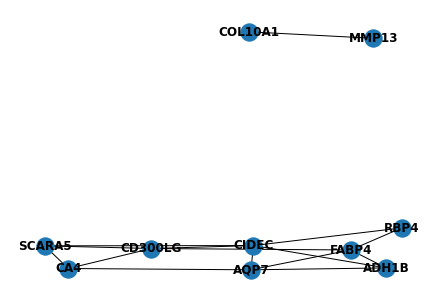

In [21]:
predicted_graph_brca = pca_cmi(tcga_data_brca_df, 0.05, 20, "HumanCancer_BRCA")



Final Prediction:
-----------------
Order : 4
Number of edges in the predicted graph : 12


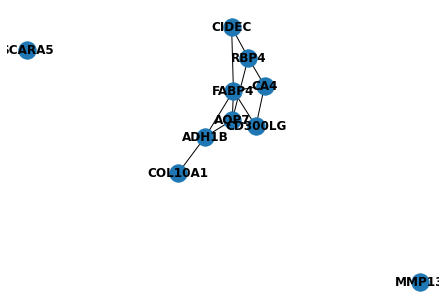

In [22]:
predicted_graph_breastnormal = pca_cmi(tcga_data_breastnormal_df, 0.05, 20, "HumanCancer_BreastNormal")